#### Evaluation

Courtesy of Otani et al.
https://github.com/mayu-ot/rethinking-evs

@misc{otani2019rethinking,
      title={Rethinking the Evaluation of Video Summaries}, 
      author={Mayu Otani and Yuta Nakashima and Esa Rahtu and Janne Heikkilä},
      year={2019},
      eprint={1903.11328},
      archivePrefix={arXiv},
      primaryClass={cs.CV}
}

modifications by Felicia Elfrida Tjhai
- phi and jaccard metrics
- MachineEvaluator
- ImportanceScoreEvaluator
- plot_summary_curves
- compare_importance_scores
- adjusting HumanEvaluator to be able to read the Breakfast Actions dataset

In [1]:
cd ../

C:\Users\felic\Documents\Research_project


In [2]:
from scipy.stats import kendalltau, spearmanr
from scipy.stats import rankdata
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import jaccard_score
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import sys
sys.path.append('src/')

import os
import h5py

In [6]:
def get_dataset(path):
    datasets_dict = {}
    _, base_filename = os.path.split(path)
    base_filename, _ = os.path.splitext(base_filename)
    datasets_dict[base_filename] = h5py.File(path, 'r')
    
    return datasets_dict[base_filename]

def get_rc_func(metric):
    if metric == 'kendalltau':
        print("kendall")
        f = lambda x, y: kendalltau(rankdata(-x), rankdata(-y))
    elif metric == 'spearmanr':
        f = lambda x, y: spearmanr(x, y)
    elif metric == 'phi':
        f = lambda x, y: matthews_corrcoef(x, y)
    elif metric == 'jaccard':
        f = lambda x, y: jaccard_score(x, y)
    else:
        raise RuntimeError
    return f

class RankCorrelationEvaluator(object):
    
    def __call__(self):
        res = []
        for d in data:
            user_anno = d['user_anno'].T
            N = user_anno.shape[1]

            D = []
            mean_tau = []
            min_tau = []
            max_tau = []

            pred_x = self.get_score(d['video'])
            D = [self.rc_func(x, pred_x)[0] for x in user_anno]

            res.append({'video': d['video'],
                        'mean': np.mean(D),
                       'min': np.min(D), 
                       'max': np.max(D), 
                        'cc': np.asarray(D)
                       })
        return res

class MachineEvaluator(RankCorrelationEvaluator):
    def __init__(self, metric, dataset):
        self.rc_func = get_rc_func(metric)
        self.dataset = dataset
        
    def __call__(self):
        res = []
        for d in self.dataset.items():
            user_anno = d[1]['user_summary'][...]
            
            N = user_anno.shape[1]

            D = []
            mean_tau = []
            min_tau = []
            max_tau = []

            pred_x = d[1]['machine_summary'][...]

            D = [self.rc_func(x, np.array(pred_x)) for x in user_anno]

            res.append({'video': d[1]['video_name'],
                        'mean': np.mean(D),
                       'min': np.min(D), 
                       'max': np.max(D), 
                        'cc': np.asarray(D)
                       })
        return res

class HumanEvaluator(RankCorrelationEvaluator):
    def __init__(self, metric, dataset):
        self.rc_func = get_rc_func(metric)
        self.dataset = dataset
        
    
    def __call__(self):
        res = []
        for d in self.dataset.items():
            user_anno = d[1]['user_summary'][...]
            
            N = user_anno.shape[1]
            
            max_rc = []
            min_rc = []
            avr_rc = []
            rc = []
            
            for i, x in enumerate(user_anno):
                
                R = [self.rc_func(x, user_anno[j]) for j in range(len(user_anno)) if j != i]
                
                max_rc.append(max(R))
                min_rc.append(min(R))
                avr_rc.append(np.mean(R))
                rc += R
#                 'video': d['video_name'][()],
            res.append({'video': d[1]['video_name'],
                        'mean': np.mean(avr_rc),
                       'min': np.mean(min_rc), 
                       'max': np.mean(max_rc), 
                        'cc': np.asarray(rc)
                       })
        return res

class ImportanceScoreEvaluator(RankCorrelationEvaluator):
    def __init__(self, metric, dataset):
        self.rc_func = get_rc_func(metric)
        self.dataset = dataset
        
    def __call__(self):
        
        res = []
        for d in self.dataset.items():
            
            ground_truth = d[1]['gtscore'][...]
            
            pred_x = d[1]['importance_scores'][...]
#             print(len(ground_truth), len(pred_x))


            D = self.rc_func(ground_truth, np.array(pred_x))[0]
            
            res.append({'video': d[1]['video_name'][()],
                'value': D
               
               })

        return res
    
def plot_summary_curves(video_name, dataset):
#     print(dataset[video_name]['user_summary'])
    this_video = dataset[video_name]
    user_summary = this_video['user_summary'][...]
    pred = this_video['machine_summary'][...]
    scores = this_video['gtscore'][...]
    for i,summ in enumerate(user_summary):
        p2 = plt.plot(summ, color='lightcoral', linewidth=3)

        p1 = plt.plot(pred,  linestyle='--')

        plt.legend((p1[0], p2[0]), ('VASNet summary', 'Human summary'))
        plt.show()

def compare_importance_scores(video_name, dataset):
    this_video = dataset[video_name]
    scores = this_video['importance_scores'][...]
    gtscores = this_video['gtscore'][...]
    pred_sum = this_video['machine_summary'][...]
#     print(scores)
    
    fig, ax = plt.subplots()
    ax.plot(scores, color="red")
    ax.set_xlabel("frame")
    ax.set_ylabel("predicted importance scores", color="red")
    
    ax2 = ax.twinx()
    ax2.plot(gtscores, color="blue")
    ax2.set_ylabel("ground-truth importance scores", color="blue")
    
    
#     p1 = plt.plot(gtscores,  linestyle='--')
#     p2 = plt.plot(scores, color='black')
#     p3 = plt.plot (pred_sum, color= 'lightcoral')
#     plt.legend((p1[0], p2[0], p3[0]), ('ground truth importance scores', 'predicted importance scores', 'predicted summary'))
#     plt.savefig('./graphs/' + video_name + '/scores.png')
    plt.show()

In [7]:
breakfast_data =  get_dataset('./results/breakfast_results.h5')['breakfast_summarization_dataset']
summe_data = get_dataset('./results/summe_results.h5')['eccv16_dataset_summe_google_pool5']
tvsum_data = get_dataset('./results/tvsum_results.h5')['eccv16_dataset_tvsum_google_pool5']

### Evaluating Breakfast Actions dataset

#### Human correlation

In [8]:
metric = 'phi'
human_phi = HumanEvaluator(metric, breakfast_data)()
print([[x['video'][()],x['mean']] for x in human_phi])
human_phi_mean = np.asarray([x['mean'] for x in human_phi])
print('human'+': mean %.3f'%(np.mean(human_phi_mean)))
print('human'+': standard deviation %.3f'%(np.std(human_phi_mean)))

[['P03_webcam02_P03_friedegg', 0.09484906949445983], ['P03_webcam02_P03_sandwich', 0.06932885340642816], ['P05_cam01_P05_coffee', 0.09180645343444355], ['P05_cam01_P05_scrambledegg', -0.28687066430883607], ['P07_cam01_P07_scrambledegg', 0.15477729765837497], ['P09_cam01_P09_scrambledegg', 0.13333090910589104], ['P10_webcam01_P10_coffee', 0.4410647298507557], ['P12_cam01_P12_sandwich', 0.6994481089980789], ['P25_cam01_P25_cereals', 0.6006378582041177], ['P29_cam01_P29_juice', 0.21950813131908864], ['P37_cam01_P37_sandwich', 0.3174849141552088], ['P38_cam01_P38_scrambledegg', 0.18178320159902941], ['P39_webcam02_P39_sandwich', 0.020817331624514643], ['P40_cam02_P40_milk', 0.15177904520153393], ['P42_cam02_P42_salat', 0.057775063249837715], ['P46_cam01_P46_tea', 0.31103734098551744], ['P47_webcam02_P47_juice', 0.3611305919848852], ['P48_cam01_P48_scrambledegg', 0.413120546662252], ['P48_cam02_P48_milk', 1.0], ['P51_cam01_P51_juice', 0.6832433425387159], ['P51_webcam01_P51_cereals', 0.5130

In [17]:
metric = 'jaccard'
human_jaccard = HumanEvaluator(metric, breakfast_data)()
human_jaccard_mean = np.asarray([x['mean'] for x in human_jaccard])
print(human_jaccard_mean)
print('human'+': mean %.3f'%(np.mean(human_jaccard_mean)))
print('human'+': standard deviation %.3f'%(np.std(human_jaccard_mean)))

[0.21385893 0.15459723 0.16666667 0.         0.22524447 0.26629274
 0.43815491 0.66       0.61548273 0.30896057 0.36789368 0.33333333
 0.11896552 0.27336678 0.21607573 0.32077709 0.5        0.35252135
 1.         0.70405644 0.55842793]
human: mean 0.371
human: standard deviation 0.228


#### Machine summary correlation

In [9]:
metric = 'phi'
machine_phi = MachineEvaluator(metric, breakfast_data)()
print("means", [x['mean'] for x in machine_phi])
# machine_phi_mean = np.asarray([x['mean'] for x in machine_phi])
machine_phi_max = np.asarray([x['max'] for x in machine_phi])
print("maxs", machine_phi_max)
# print('machine'+': mean of mean %.3f'%(np.mean(machine_phi_mean)))
print('machine'+': mean of max %.3f'%(np.mean(machine_phi_max)))
print('machine'+': standard deviation %.3f'%(np.std(machine_phi_max)))

means [0.07000729641838305, -0.02435981339444922, 0.22739242678104615, -0.005396746080985629, -0.09497544151123673, 0.24732125378152478, 0.28678542860859396, 0.3938600386471782, -0.06817347457946708, 0.005484604323075473, 0.12276987914125018, 0.1639076863750495, 0.30388514233730457, 0.11470741810198122, 0.29137233930281053, 0.19216762908475532, 0.005854181075873925, 0.6685658066286617, 0.5887014142200897, 0.57196841297149, 0.34639408826172574]
maxs [0.38442772 0.69357295 0.30798824 0.18749127 0.37718756 0.53114137
 0.89188259 0.39889622 0.66648368 0.61350956 0.64994257 0.6680812
 0.9204298  0.91499142 0.97968347 0.92954962 0.64246907 0.74100434
 0.58870141 0.69581545 0.5433151 ]
machine: mean of max 0.635
machine: standard deviation 0.214


In [79]:
metric = 'jaccard'
machine_jaccard = MachineEvaluator(metric, breakfast_data)()
print([[x['mean'], x['max']] for x in machine_jaccard])
# machine_jaccard_mean = np.asarray([x['mean'] for x in machine_jaccard])
machine_jaccard_max = np.asarray([x['max'] for x in machine_jaccard])
print(machine_jaccard_max)
# print('machine'+': mean of mean %.3f'%(np.mean(machine_jaccard_mean)))
print('machine'+': mean of max %.3f'%(np.mean(machine_jaccard_max)))
print('machine'+': standard deviation %.3f'%(np.std(machine_jaccard_max)))

[[0.13405750490464094, 0.3050847457627119], [0.07333333333333333, 0.55], [0.22086466165413532, 0.2631578947368421], [0.09836065573770492, 0.19672131147540983], [0.046620046620046623, 0.30303030303030304], [0.2222222222222222, 0.38095238095238093], [0.27496518398573, 0.8181818181818182], [0.316923076923077, 0.32], [0.07467532467532467, 0.5454545454545454], [0.12, 0.48], [0.15287653522947642, 0.5], [0.24242424242424243, 0.48484848484848486], [0.3332355816226784, 0.8666666666666667], [0.19642857142857142, 0.8571428571428571], [0.3691852955488937, 0.9642857142857143], [0.22411242603550294, 0.875], [0.125, 0.5], [0.518796992481203, 0.6052631578947368], [0.45454545454545453, 0.45454545454545453], [0.4950419527078567, 0.5789473684210527], [0.3034188034188034, 0.4166666666666667]]
[0.30508475 0.55       0.26315789 0.19672131 0.3030303  0.38095238
 0.81818182 0.32       0.54545455 0.48       0.5        0.48484848
 0.86666667 0.85714286 0.96428571 0.875      0.5        0.60526316
 0.45454545 0.5

#### Importance score correlation

In [9]:
metric = 'spearmanr'
impo_spearman = ImportanceScoreEvaluator(metric, breakfast_data)()
impo_corr = [x['value'] for x in impo_spearman]
print('imp scores'+': mean %.3f'%(np.mean(impo_corr)))
print('imp scores'+': standard deviation %.3f'%(np.std(impo_corr)))

imp scores: mean 0.045
imp scores: standard deviation 0.224


In [8]:
metric = 'kendalltau'
impo_spearman = ImportanceScoreEvaluator(metric, breakfast_data)()
impo_corr = [x['value'] for x in impo_spearman]
print('imp scores'+': mean %.3f'%(np.mean(impo_corr)))
print('imp scores'+': standard deviation %.3f'%(np.std(impo_corr)))

kendall
imp scores: mean 0.037
imp scores: standard deviation 0.171


#### Visualization

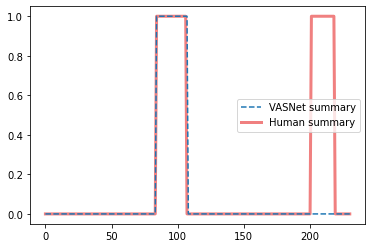

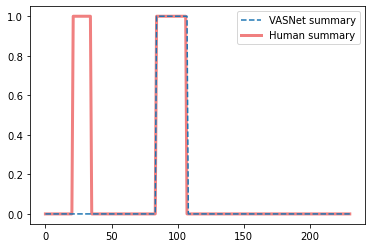

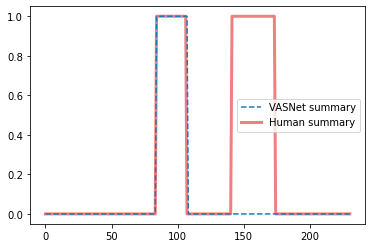

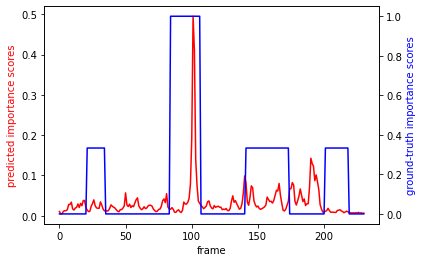

In [86]:
video = "P48_cam01_P48_scrambledegg"
plot_summary_curves(video, breakfast_data)
compare_importance_scores(video, breakfast_data)

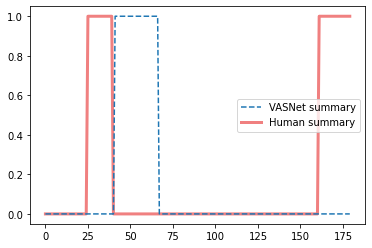

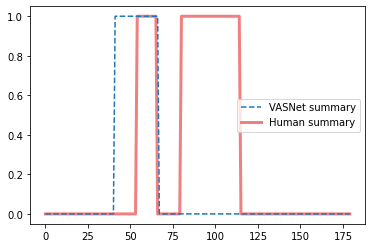

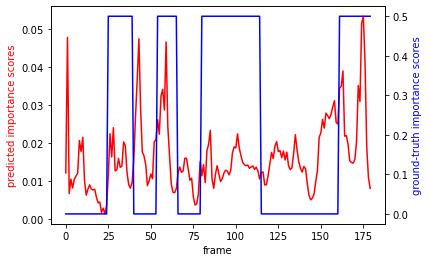

In [10]:
video = "P05_cam01_P05_scrambledegg"

plot_summary_curves(video, breakfast_data)
compare_importance_scores(video, breakfast_data)

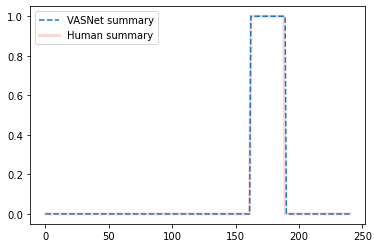

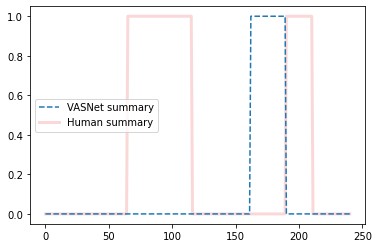

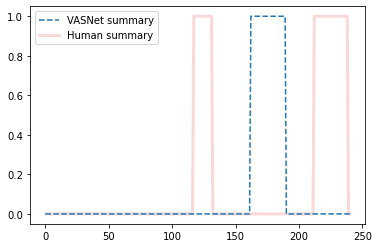

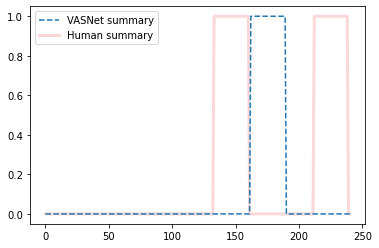

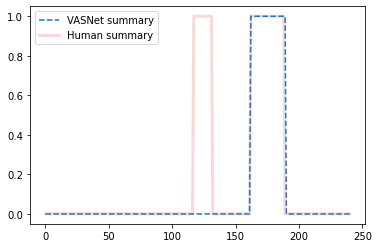

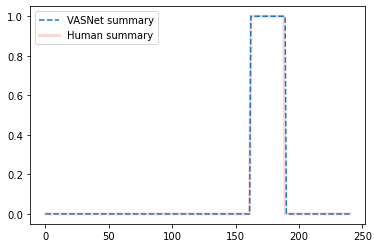

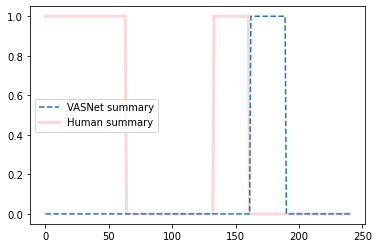

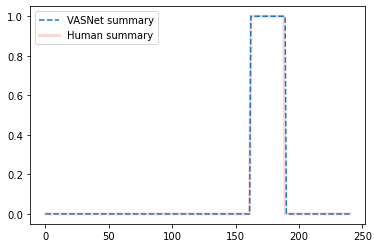

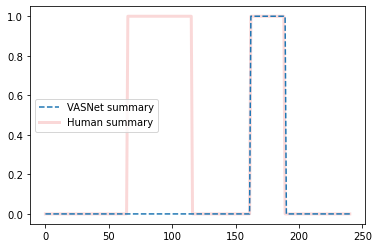

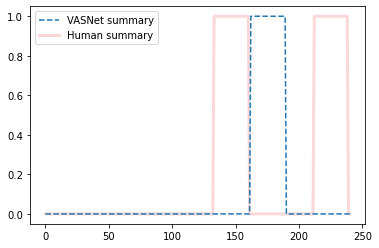

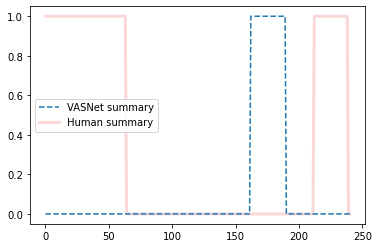

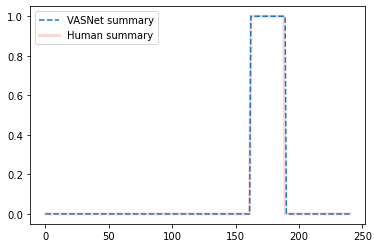

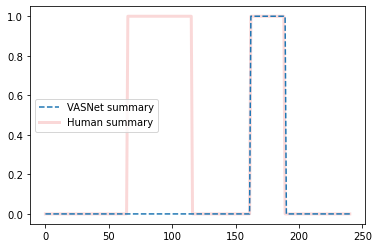

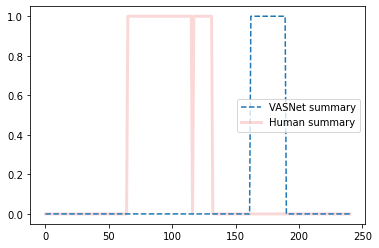

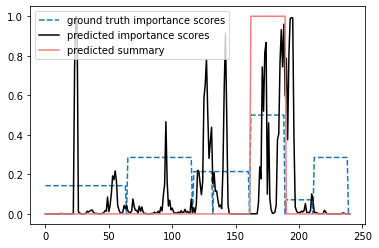

In [46]:
video = "P42_cam02_P42_salat"

plot_summary_curves(video, breakfast_data)
compare_importance_scores(video, breakfast_data)

### Evaluating SumMe dataset

#### Human correlation

In [15]:
metric = 'phi'
human_phi = HumanEvaluator(metric, summe_data)()
human_phi_mean = np.asarray([x['mean'] for x in human_phi])
print('human'+': mean %.3f'%(np.mean(human_phi_mean)))
print('human'+': standard deviation %.3f'%(np.std(human_phi_mean)))

human: mean 0.212
human: standard deviation 0.107


In [16]:
metric = 'jaccard'
human_jaccard = HumanEvaluator(metric, summe_data)()
human_jaccard_mean = np.asarray([x['mean'] for x in human_jaccard])
print('human'+': mean %.3f'%(np.mean(human_jaccard_mean)))
print('human'+': standard deviation %.3f'%(np.std(human_jaccard_mean)))

human: mean 0.198
human: standard deviation 0.071


#### Machine summary correlation

In [11]:
metric = 'phi'
machine_phi = MachineEvaluator(metric, summe_data)()
machine_phi_max = np.asarray([x['max'] for x in machine_phi])
print('machine'+': mean of max %.3f'%(np.mean(machine_phi_max)))
print('machine'+': standard deviation %.3f'%(np.std(machine_phi_max)))

machine: mean of max 0.448
machine: standard deviation 0.162


In [12]:
metric = 'jaccard'
machine_phi = MachineEvaluator(metric, summe_data)()
machine_jaccard_max = np.asarray([x['max'] for x in machine_phi])
print('machine'+': mean of max %.3f'%(np.mean(machine_jaccard_max)))
print('machine'+': standard deviation %.3f'%(np.std(machine_jaccard_max)))

machine: mean of max 0.354
machine: standard deviation 0.127


#### Importance score correlation

In [13]:
metric = 'spearmanr'
impo_spearman = ImportanceScoreEvaluator(metric, summe_data)()
impo_corr = [x['value'] for x in impo_spearman]
print('imp scores'+': mean %.3f'% (np.mean(impo_corr)))
print('imp scores'+': standard deviation %.3f'%(np.std(impo_corr)))

imp scores: mean 0.032
imp scores: standard deviation 0.223


In [14]:
metric = 'kendalltau'
impo_spearman = ImportanceScoreEvaluator(metric, summe_data)()
impo_corr = [x['value'] for x in impo_spearman]
print('imp scores'+': mean %.3f'% (np.mean(impo_corr)))
print('imp scores'+': standard deviation %.3f'%(np.std(impo_corr)))

kendall
imp scores: mean 0.025
imp scores: standard deviation 0.164


In [76]:
f_scores = []
for d in summe_data.items():
    f_scores.append(d[1]['fm'][()])
np.mean(f_scores), np.std(f_scores)

(0.5105407838653983, 0.1375630057127202)

### Evaluating TVSum dataset

#### Human correlation

In [17]:
metric = 'phi'
human_phi = HumanEvaluator(metric, tvsum_data)()
human_phi_mean = np.asarray([x['mean'] for x in human_phi])
print('human'+': mean %.3f'%(np.mean(human_phi_mean)))
print('human'+': standard deviation %.3f'%(np.std(human_phi_mean)))

human: mean 0.458
human: standard deviation 0.096


In [18]:
metric = 'jaccard'
human_jaccard = HumanEvaluator(metric, tvsum_data)()
human_jaccard_mean = np.asarray([x['mean'] for x in human_jaccard])
print('human'+': mean %.3f'%(np.mean(human_jaccard_mean)))
print('human'+': standard deviation %.3f'%(np.std(human_jaccard_mean)))

human: mean 0.387
human: standard deviation 0.079


#### Machine correlation

In [19]:
metric = 'phi'
machine_phi = MachineEvaluator(metric, tvsum_data)()
machine_phi_mean = np.asarray([x['mean'] for x in machine_phi])
print('machine'+': mean of mean %.3f'%(np.mean(machine_phi_mean)))
print('machine'+': standard deviation %.3f'%(np.std(machine_phi_mean)))

machine: mean of mean 0.537
machine: standard deviation 0.100


In [20]:
metric = 'jaccard'
machine_jaccard = MachineEvaluator(metric, tvsum_data)()
machine_jaccard_mean = np.asarray([x['mean'] for x in machine_jaccard])
print('human'+': mean of mean %.3f'%(np.mean(machine_jaccard_mean)))
print('machine'+': standard deviation %.3f'%(np.std(machine_jaccard_mean)))

human: mean of mean 0.453
machine: standard deviation 0.094


#### Importance score correlation

In [21]:
metric = 'spearmanr'
impo_spearman = ImportanceScoreEvaluator(metric, tvsum_data)()
impo_corr = [x['value'] for x in impo_spearman]
print('imp scores'+': mean %.3f'% (np.mean(impo_corr)))
print('imp scores'+': standard deviation %.3f'%(np.std(impo_corr)))

imp scores: mean 0.438
imp scores: standard deviation 0.232


In [22]:
metric = 'kendalltau'
impo_spearman = ImportanceScoreEvaluator(metric, tvsum_data)()
impo_corr = [x['value'] for x in impo_spearman]
print('imp scores'+': mean %.3f'% (np.mean(impo_corr)))
print('imp scores'+': standard deviation %.3f'%(np.std(impo_corr)))

kendall
imp scores: mean 0.306
imp scores: standard deviation 0.168


In [74]:
f_scores = []
for d in tvsum_data.items():
    f_scores.append(d[1]['fm'][()])
np.mean(f_scores), np.std(f_scores)

(0.6056586876865068, 0.08503744814359147)